In [268]:
import torch
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
import itertools

In [281]:
# DETERMINE THE PATHS
path_related = '../runs/lstm_max_len_5_vocab_5_same_data_attr_4_related_split_2/'
path = '../runs/lstm_max_len_5_vocab_5_same_data_attr_4_split_2/'
TOKENS = 8

save_path = "Experiments/"

# SET WHICH EXPERIMENT TO CHECK
related = False;

# DETERMINE THE SEED
seed = '8'

In [282]:
# FUNCTIONS

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# Load corpi

In [283]:
# load corpus

if related:
    train_messages = pickle.load(open(path_related + seed + '/metrics_at_10000.pkl', 'rb'))['messages']
    train_messages = train_messages[0::4]
    
    # check if gen has a path
    if not os.path.exists(path_related + seed + '/generalize_metrics.pkl'):
        messages = train_messages
    else:
        gen_messages = pickle.load(open(path_related + seed + '/generalize_metrics.pkl', 'rb'))['messages']
        messages = np.concatenate((train_messages,gen_messages))
else:
    train_messages = pickle.load(open(path + seed + '/metrics_at_10000.pkl', 'rb'))['messages']
    
    if not os.path.exists(path + seed + '/generalize_metrics.pkl'):
        messages = train_messages
    else:
        gen_messages = pickle.load(open(path + seed + '/generalize_metrics.pkl', 'rb'))['messages']
        messages = np.concatenate((train_messages,gen_messages))
        
print(messages.shape)


(625, 6)


# Get sentence index and sequence index of every token


In [284]:
# get all tokens
tokens = np.arange(TOKENS)

# create dictionary for holding all the indices
index_dict = {}

sample_sizes = []

# loop for every token through the 
for token in tokens:
    indices = list(zip(*np.where(messages == token)))
    
    processed_indices = []
    
    # get the size
    size = len(indices)
    
    # append size to sample size
    sample_sizes.append(size)

    # loop through indices
    for i in range(size):
        
        # change every 2nd index by 1, because we skip the contributions of biases and initialization
        index = list(indices[i])
        index[1] += 1
        processed_indices.append(index)

    # store the indices
    index_dict[token] = processed_indices   
    

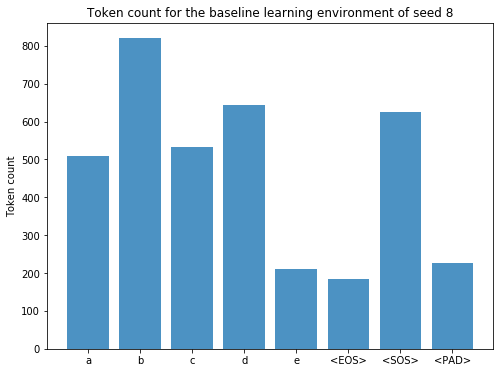

In [285]:
# figure stats
fig, ax = plt.subplots(figsize=(8,6))
labels = ['0','a', 'b', 'c', 'd', 'e', '<EOS>', '<SOS>', '<PAD>']
index = np.arange(TOKENS)

# bar stats
bar_width = 0.8


# bar for the message-input RSA
bar = ax.bar(index, sample_sizes, bar_width, alpha=0.8)

plt.ylabel('Token count')

if related:
    plt.title('Token count for the strict learning environment of seed ' + seed)
else:
    plt.title('Token count for the baseline learning environment of seed ' + seed)
    
ax.set_xticklabels(labels)
plt.show()




# Create co-occurency plot

In [286]:
# need targets for this
# load targets

if related:
    train_targets = pickle.load(open(path_related + seed + '/metrics_at_10000.pkl', 'rb'))['targets']
    train_targets = train_targets[0::4]
    
    # check if gen has a path
    if not os.path.exists(path_related + seed + '/generalize_metrics.pkl'):
        targets = train_targets
    else:
        gen_targets = pickle.load(open(path_related + seed + '/generalize_metrics.pkl', 'rb'))['targets']
        targets = np.concatenate((train_targets, gen_targets))
else:
    train_targets = pickle.load(open(path + seed + '/metrics_at_10000.pkl', 'rb'))['targets']
    
    if not os.path.exists(path + seed + '/generalize_metrics.pkl'):
        targets = train_targets
    else:
        gen_targets = pickle.load(open(path + seed + '/generalize_metrics.pkl', 'rb'))['targets']
        targets = np.concatenate((train_targets, gen_targets))
        
print(targets.shape)


(625, 20)


In [287]:
# get the co occurences

# we initialize a matrix of a to eos --> 6
occurences = np.zeros((TOKENS-2, targets.shape[1]))

# loop through all targets
for message, target in zip(messages, targets):
    
    # get which features are depicted in the object
    features = np.where(target==1)[0]
    
    # use message as index for the tokens
    # relieve it of the sos token
    message = message[1:]
    
    # relieve it of the padding
    message = list(itertools.takewhile(lambda x: not x == 7, message))

    # now we use the message and features as index for the matrix
    for feature in features:
        occurences[message, feature] += 1

    
# for every 1, we add +1 to the messages in the matrix
print(occurences)

[[ 88.   0.  50.   0.  65.   0.  75.  13.  40.  75.  41.  41.  40.  41.
   40.  40.  40.  43.  40.  40.]
 [ 48.  75.  75.  60.  77.  85.   0.   2. 123. 125.  65.  65.  70.  65.
   70.  67.  67.  67.  67.  67.]
 [ 50.   0.  75.   0.  75.  50.   0.  75.  75.   0.  40.  40.  40.  40.
   40.  40.  40.  40.  40.  40.]
 [  0.  75.  60.  75.  46.  98.   0.  98.  60.   0.  50.  50.  53.  50.
   53.  52.  52.  48.  52.  52.]
 [  0.  13.  22.  51.   2.  15.  58.   0.   0.  15.  18.  19.  16.  14.
   21.  20.  13.  22.  19.  14.]
 [  0. 125.  25.   8.  25.  25.  83.  25.  25.  25.  37.  37.  37.  37.
   35.  35.  39.  35.  35.  39.]]


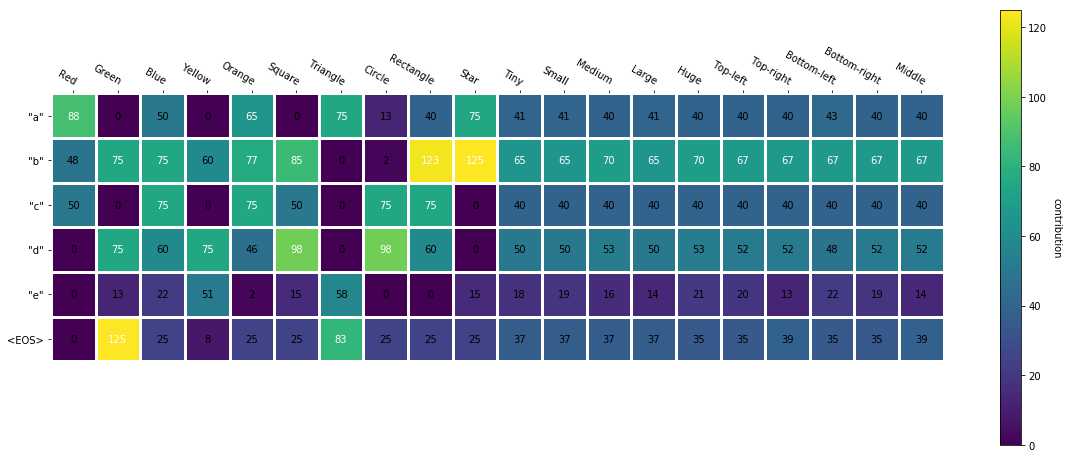

In [288]:
tokens = ['"a"', '"b"', '"c"', '"d"', '"e"', "<EOS>"]

features = ["Red", "Green", "Blue", "Yellow", "Orange",
            "Square", "Triangle", "Circle", "Rectangle", "Star",
            "Tiny", "Small", "Medium", "Large", "Huge",
            "Top-left", "Top-right", "Bottom-left", "Bottom-right", "Middle"]

fig, ax = plt.subplots(figsize=(20,8))

im, cbar = heatmap(occurences, tokens, features, ax=ax, cbarlabel="contribution")
texts = annotate_heatmap(im, valfmt="{x:.0f}")


In [278]:
# so does this seed actually use a and b for the generalize?
print(gen_messages)
# print(gen_targets)

# load matrix
if related:
    gcd_matrix = pickle.load(open(seed + '/GCDmatrix_related.p', 'rb'))
else:
    gcd_matrix = pickle.load(open(seed + '/GCDmatrix.p', 'rb'))
    

# cut initial part of matrix
gcd_matrix = gcd_matrix[:,1:,:]

contributions = gcd_matrix[example,:,:]

# get sentence example
example = 601

# extract sequence and convert to token indices
mess = messages[example]

# possible tokens
tokens = ['"a"', '"b"', '"c"', '"d"', '"e"', "<EOS>", "<SOS>"]

labels = []
for t in mess:
    labels.append(tokens[t])

features = ["Red", "Green", "Blue", "Yellow", "Orange",
            "Square", "Triangle", "Circle", "Rectangle", "Star",
            "Tiny", "Small", "Medium", "Large", "Huge",
            "Top-left", "Top-right", "Bottom-left", "Bottom-right", "Middle"]

fig, ax = plt.subplots(figsize=(20,8))

im, cbar = heatmap(gcd_matrix[example,:,:], labels, features, ax=ax, cbarlabel="contribution")
texts = annotate_heatmap(im, valfmt="{x:.03f}")



[[6 4 4 4 4 4]
 [6 4 4 4 4 0]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 3 4 0 0 0]
 [6 4 4 4 4 2]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 3 3 0 0 0]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 3 4 0 0 0]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 4 4 0 0 0]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 4 4 4 4 4]
 [6 4 4 0 0 0]]


FileNotFoundError: [Errno 2] No such file or directory: '6/GCDmatrix.p'

# Extract token contributions from GCD matrix

In [6]:
# load matrix
if related:
    matrix = pickle.load(open(save_path + seed + '/GCDmatrix_related.p', 'rb'))
else:
    matrix = pickle.load(open(save_path + seed + '/GCDmatrix.p', 'rb'))
    
# convert to numpy
matrix = matrix.numpy()

# get the tokens
tokens = np.arange(TOKENS)

results = {}

# loop through tokens
for token in tokens:
    
    # need a list to save all the activations
    results[token] = []
    
    # loop through indices
    for index in index_dict[token]:
        
        # extract correct activation from matrix
        activation = matrix[index[0], index[1], :]

        # add activation to result dict
        results[token].append(activation)  


# Get averages
Convert ordered dict to a single large matrix that holds all of the averages

In [7]:
# create large list for all average values
avg_matrix = []

# loop through dict values -> contributions
for result in results.values():

    # get average of all vectors
    data = np.array(result)
    
    if len(data) == 0:
        avg_matrix.append(np.zeros(20,))
    else:
        
        # get the average
        avg = np.mean(data, 0)
        avg_matrix.append(avg)
        
print(np.array(avg_matrix).shape)

(24, 24)


# Plot results
We know have an ordered dictionary that holds the tokens as keys, and all their respective activations to the object features as values. Here we plot the result.

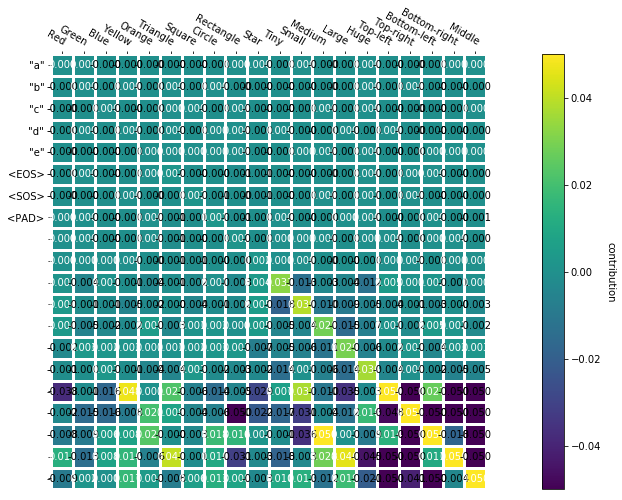

In [43]:
tokens = ['"a"', '"b"', '"c"', '"d"', '"e"', "<EOS>", "<SOS>", "<PAD>"]

features = ["Red", "Green", "Blue", "Yellow", "Orange",
            "Triangle", "Square", "Circle", "Rectangle", "Star",
            "Tiny", "Small", "Medium", "Large", "Huge",
            "Top-left", "Top-right", "Bottom-left", "Bottom-right", "Middle"]

contributions = np.array(avg_matrix)

contributions = np.clip(contributions, -0.05, 0.05)


fig, ax = plt.subplots(figsize=(20,8))

im, cbar = heatmap(contributions, tokens, features, ax=ax, cbarlabel="contribution")
texts = annotate_heatmap(im, valfmt="{x:.3f}")


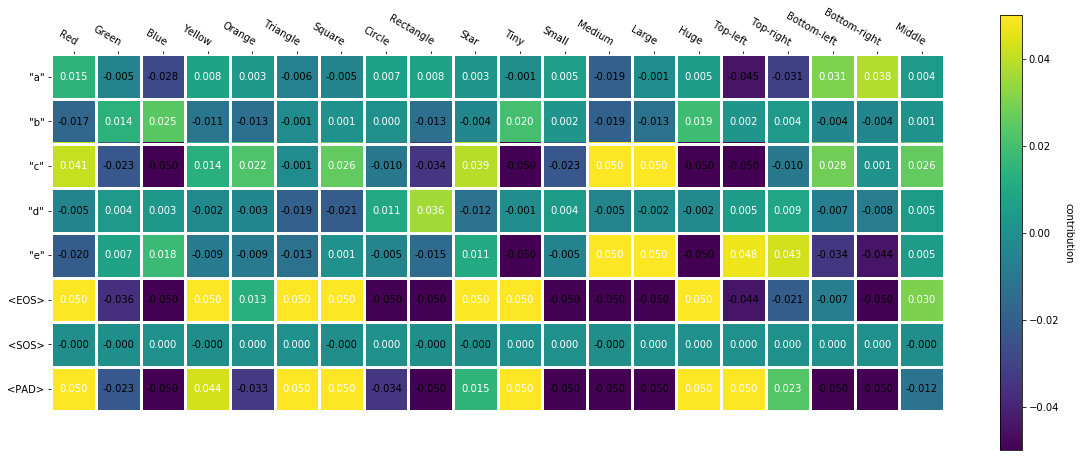

In [270]:
tokens = ['"a"', '"b"', '"c"', '"d"', '"e"', "<EOS>", "<SOS>", "<PAD>"]

features = ["Red", "Green", "Blue", "Yellow", "Orange", "Triangle", "Square", "Circle", "Rectangle", "Star",
            "Tiny", "Small", "Medium", "Large", "Huge", "Top-left", "Top-right", "Bottom-left", "Bottom-right", "Middle"]

contributions = np.array(avg_matrix)

contributions = np.clip(contributions, -0.05, 0.05)


fig, ax = plt.subplots(figsize=(20,8))

im, cbar = heatmap(contributions, tokens, features, ax=ax, cbarlabel="contribution")
texts = annotate_heatmap(im, valfmt="{x:.3f}")


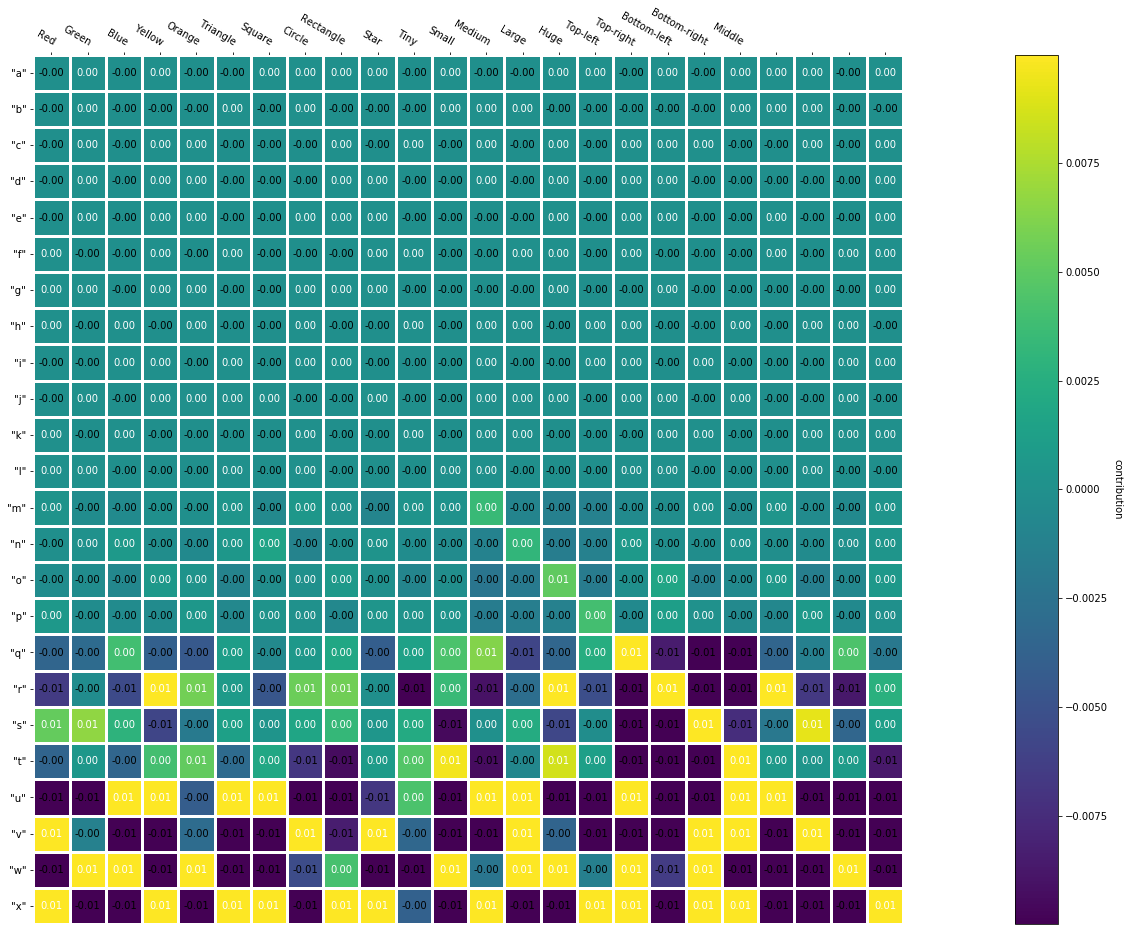

In [127]:
tokens = []
for i in range(24):
    token = '"' + chr(97+i) + '"'
    tokens.append(token)

features = ["Red", "Green", "Blue", "Yellow", "Orange",
            "Triangle", "Square", "Circle", "Rectangle", "Star",
            "Tiny", "Small", "Medium", "Large", "Huge",
            "Top-left", "Top-right", "Bottom-left", "Bottom-right", "Middle"]

contributions = np.array(avg_matrix)

contributions = np.clip(contributions, -0.01, 0.01)


fig, ax = plt.subplots(figsize=(40,16))

im, cbar = heatmap(contributions, tokens, features, ax=ax, cbarlabel="contribution")
texts = annotate_heatmap(im, valfmt="{x:.2f}")


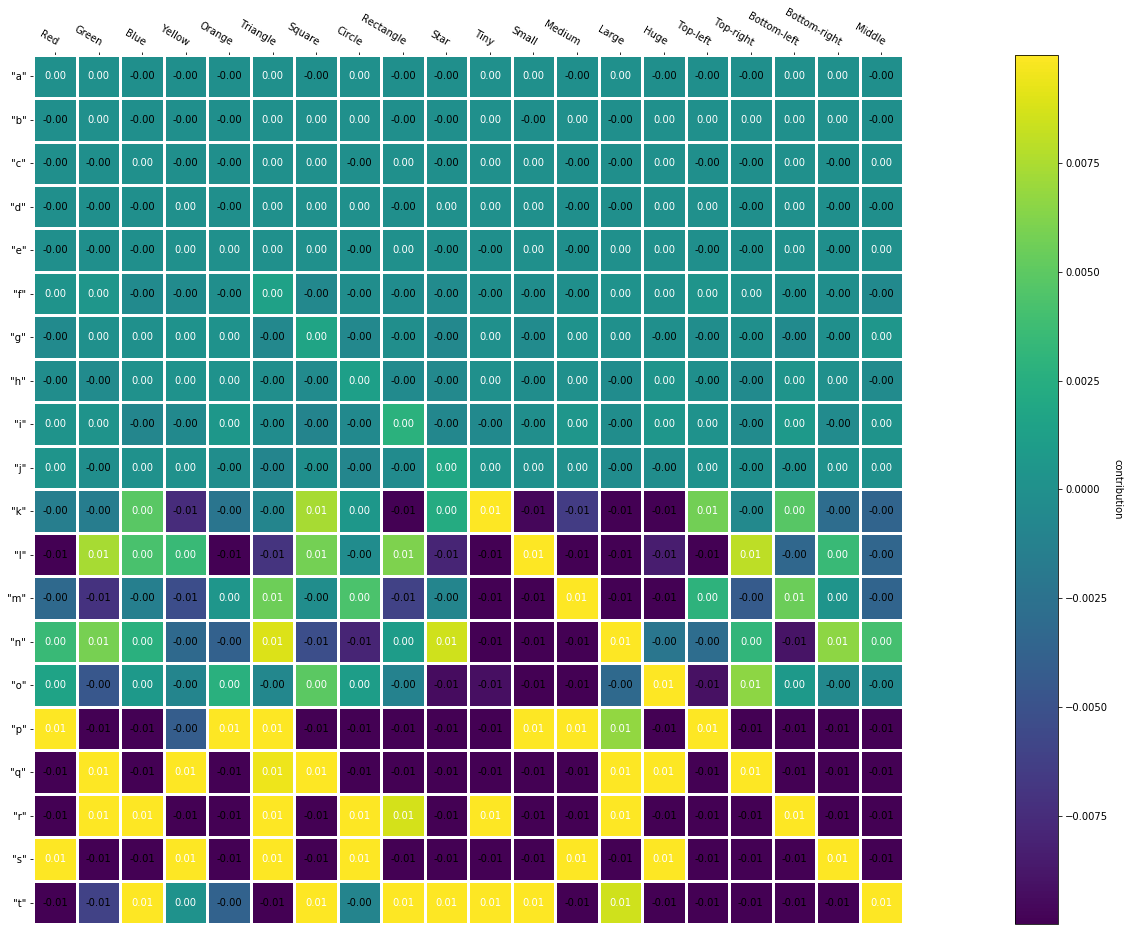

In [82]:
tokens = []
for i in range(20):
    token = '"' + chr(97+i) + '"'
    tokens.append(token)

features = ["Red", "Green", "Blue", "Yellow", "Orange",
            "Triangle", "Square", "Circle", "Rectangle", "Star",
            "Tiny", "Small", "Medium", "Large", "Huge",
            "Top-left", "Top-right", "Bottom-left", "Bottom-right", "Middle"]

contributions = np.array(avg_matrix)

contributions = np.clip(contributions, -0.01, 0.01)


fig, ax = plt.subplots(figsize=(40,16))

im, cbar = heatmap(contributions, tokens, features, ax=ax, cbarlabel="contribution")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
